In [ ]:
"""
Problem Statement : Use auto encoder to implement anomaly detection 
Objectives : 
            1. To study how auto encoders works
            2. To perform following task as per sequence
                a. Import required libraries
                b. Upload / access the dataset
                c. Encoder converts it into latent representation
                d. Decoder networks convert it back to the original input
                e. Compile the models with Optimizer, Loss, and Evaluation Metrics

Theory : 

        Autoencoder : An autoencoder is a type of artificial neural network used for unsupervised learning and dimensionality reduction
                      It's a specific architecture designed to encode data into a lower-dimensional representation (encoding) and then decode it back into the original data

        Encoder: The encoder is the first part of the network and is responsible for compressing the input data into a lower-dimensional representation. 
                 It is a kind of feed forward neural network that reduces input data to the bottleck layer .(in the form of encoded representation).

        Decoder: The decoder takes the encoded representation and attempts to reconstruct the original input data. 
                 It's also a neural network, but it's used in reverse, expanding the bottleneck layer back to the original input dimensions.

        Anomaly Detection: Autoencoders tries to minimize the reconstruction error as part of its training. 
                           Anomalies are detected by checking the magnitude of the reconstruction loss.

        
         During the training, input only normal transactions to the Encoder. The bottleneck layer will learn the latent representation of the normal input data.
         The Decoder will use the bottleneck layers output to reconstruct the normal transactions of the original input data.
         A fraudulent transaction will be different from a normal transaction. The Autoencoder will have trouble reconstructing the fraudulent transaction, and hence the reconstruction error will be high.
         You can flag a new transaction is fraudulent based on a specified threshold value for the reconstruction error.

        Dataset  :https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download
"""

In [6]:
!pip3 install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 12.2 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.8/29.8 MB 18.0 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 16.2 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip3 install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 2.7 MB/s eta 0:00:00 MB/s eta 0:00:01

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [7]:
import pandas as pd
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

In [22]:
# import the dataset
data = pd.read_csv(r"creditcard.csv")
data=data.iloc[1:50000,]
data.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0
10,10.0,1.449044,-1.176339,0.913860,-1.375667,-1.971383,-0.629152,-1.423236,0.048456,-1.720408,...,-0.009302,0.313894,0.027740,0.500512,0.251367,-0.129478,0.042850,0.016253,7.80,0


In [13]:
# drop the "class" column ( axis=1) 
x = data.drop(["Class"], axis=1)
print(x) # remaining dataset 


          Time        V1        V2        V3        V4        V5        V6  \
1          0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2          1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3          1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4          2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   
5          2.0 -0.425966  0.960523  1.141109 -0.168252  0.420987 -0.029728   
...        ...       ...       ...       ...       ...       ...       ...   
49995  44296.0 -1.007648  0.722149  0.779027 -1.466661  0.298457 -0.263997   
49996  44297.0 -5.202399  2.077079 -3.905209  1.097967 -1.719915 -0.803272   
49997  44298.0 -1.597980 -0.363988  2.114888 -1.101263 -0.291577  0.009897   
49998  44298.0 -2.998734  2.323844 -2.419829  0.941745 -1.436231 -0.847601   
49999  44299.0  0.618650 -1.744738  0.367658 -1.486308 -1.724517 -0.818788   

             V7        V8        V9  ...       V20       V21   

In [12]:
y = data["Class"].values
print(y)

[0 0 0 ... 0 0 0]


In [15]:
print(x.values) # array of values

[[ 0.00000000e+00  1.19185711e+00  2.66150712e-01 ... -8.98309914e-03
   1.47241692e-02  2.69000000e+00]
 [ 1.00000000e+00 -1.35835406e+00 -1.34016307e+00 ... -5.53527940e-02
  -5.97518406e-02  3.78660000e+02]
 [ 1.00000000e+00 -9.66271712e-01 -1.85226008e-01 ...  6.27228487e-02
   6.14576285e-02  1.23500000e+02]
 ...
 [ 4.42980000e+04 -1.59797976e+00 -3.63988103e-01 ...  3.02803776e-01
  -2.23860598e-02  1.72140000e+02]
 [ 4.42980000e+04 -2.99873407e+00  2.32384365e+00 ...  3.75636473e-01
  -2.43936790e-02  8.99900000e+01]
 [ 4.42990000e+04  6.18649992e-01 -1.74473764e+00 ...  4.57647565e-02
   8.96612950e-02  3.39800000e+02]]


In [16]:
"""
The Min-Max Scaler is a technique that scales the data, typically to a range between 0 and 1.This method takes the features from the DataFrame x (retrieved as x.values) and scales them using the Min-Max scaling transformation. 
The result, stored in the x_scale variable, is a NumPy array containing the scaled and normalized features.
"""
x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
print("x_scale: {0}".format(x_scale))


# splits the scaled data(x_scale) into two subsets, x_norm and x_fraud, 
# based on the values in the target variable y. 
# y == 0 and y == 1 are boolean arrays that represent whether each sample in the dataset is a "normal" sample (0) or a "fraudulent" sample (1). 
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

x_scale: [[0.00000000e+00 9.86831151e-01 8.02886655e-01 ... 4.34375000e-01
  2.21614617e-01 2.08350599e-04]
 [2.25738730e-05 9.43139215e-01 7.85215310e-01 ... 4.32021612e-01
  2.19901175e-01 2.93286386e-02]
 [2.25738730e-05 9.49856634e-01 7.97920979e-01 ... 4.38014272e-01
  2.22689797e-01 9.56553866e-03]
 ...
 [9.99977426e-01 9.39033787e-01 7.95954385e-01 ... 4.50199032e-01
  2.20760836e-01 1.33328893e-02]
 [9.99977426e-01 9.15035120e-01 8.25523702e-01 ... 4.53895489e-01
  2.20714647e-01 6.97006335e-03]
 [1.00000000e+00 9.77010581e-01 7.80764514e-01 ... 4.37153603e-01
  2.23338668e-01 2.63187857e-02]]


In [23]:
print("x_norm : {0}".format(x_norm))

x_norm : [[0.00000000e+00 9.86831151e-01 8.02886655e-01 ... 4.34375000e-01
  2.21614617e-01 2.08350599e-04]
 [2.25738730e-05 9.43139215e-01 7.85215310e-01 ... 4.32021612e-01
  2.19901175e-01 2.93286386e-02]
 [2.25738730e-05 9.49856634e-01 7.97920979e-01 ... 4.38014272e-01
  2.22689797e-01 9.56553866e-03]
 ...
 [9.99977426e-01 9.39033787e-01 7.95954385e-01 ... 4.50199032e-01
  2.20760836e-01 1.33328893e-02]
 [9.99977426e-01 9.15035120e-01 8.25523702e-01 ... 4.53895489e-01
  2.20714647e-01 6.97006335e-03]
 [1.00000000e+00 9.77010581e-01 7.80764514e-01 ... 4.37153603e-01
  2.23338668e-01 2.63187857e-02]]


In [24]:
print("x_fraud : {0}".format(x_fraud))

x_fraud : [[0.00916499 0.92679683 0.8214329  ... 0.44808474 0.21797957 0.        ]
 [0.01065487 0.91426746 0.76522458 ... 0.42200199 0.22209868 0.04097304]
 [0.10072462 0.92694892 0.81931248 ... 0.436839   0.21775519 0.01858348]
 ...
 [0.97130861 0.94740026 0.8088814  ... 0.45607847 0.22313378 0.01582148]
 [0.9790063  0.90875455 0.82665308 ... 0.37391928 0.19799163 0.00681593]
 [0.98182803 0.94451354 0.80783818 ... 0.45791585 0.22444718 0.0019286 ]]


In [25]:
## -------------- input layer -------
input_layer = Input(shape=(x.shape[1],))

## ------------- encoding part ------
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

##------------- decoding part -----
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## ----------- output layer ---------
output_layer = Dense(x.shape[1], activation='relu')(decoded)

In [26]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [27]:
history=autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split =0.20)

Epoch 1/10
7/7 [==============================] - 0s 12ms/step - loss: 0.2529 - val_loss: 0.2518
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2526 - val_loss: 0.2515
Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2524 - val_loss: 0.2512
Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2521 - val_loss: 0.2510
Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2518 - val_loss: 0.2507
Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2515 - val_loss: 0.2504
Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2512 - val_loss: 0.2501
Epoch 8/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2510 - val_loss: 0.2498
Epoch 9/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2507 - val_loss: 0.2496
Epoch 10/10
7/7 [==============================] - 0s 4ms/step - loss: 0.2504 - val_loss: 0.2493


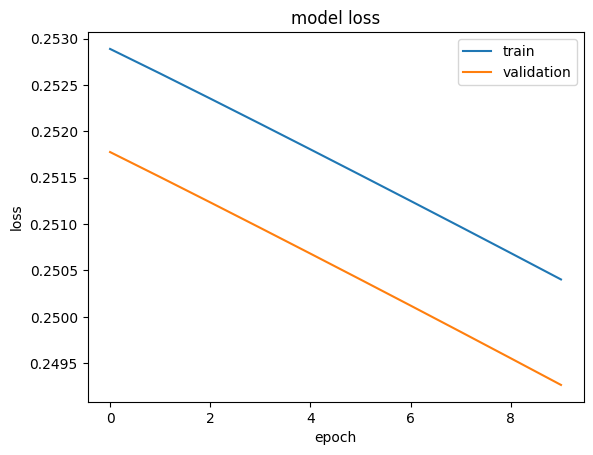

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [29]:
hid_rep = Sequential()
hid_rep.add(autoencoder.layers[0])
hid_rep.add(autoencoder.layers[1])
hid_rep.add(autoencoder.layers[2])

In [30]:
norm_hid_rep = hid_rep .predict(x_norm[:3000])
fraud_hid_rep = hid_rep .predict(x_fraud)

5/5 [==============================] - 0s 421us/step


In [33]:
print("normal: {0}".format(norm_hid_rep))
print("fraud: {0}".format(fraud_hid_rep))

normal: [[0.         0.18351111 0.         ... 0.         0.         0.06431135]
 [0.         0.22475418 0.         ... 0.         0.         0.05427399]
 [0.         0.22583312 0.         ... 0.         0.         0.14536148]
 ...
 [0.         0.16840151 0.         ... 0.         0.         0.04506403]
 [0.         0.18081215 0.         ... 0.         0.         0.08520672]
 [0.         0.24338724 0.         ... 0.         0.         0.06009329]]
fraud: [[0.         0.14294492 0.         ... 0.         0.         0.        ]
 [0.         0.13306707 0.         ... 0.         0.         0.0485657 ]
 [0.         0.17531084 0.         ... 0.         0.         0.06905442]
 ...
 [0.         0.1805662  0.         ... 0.         0.         0.        ]
 [0.         0.06489426 0.         ... 0.         0.         0.        ]
 [0.         0.06095285 0.         ... 0.         0.         0.        ]]


In [38]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

df =non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
df.head()

AttributeError: 'DataFrame' object has no attribute 'append'